# <center><font color="darkblue"> Detecting Road Debris with Deep Learning </font></center>

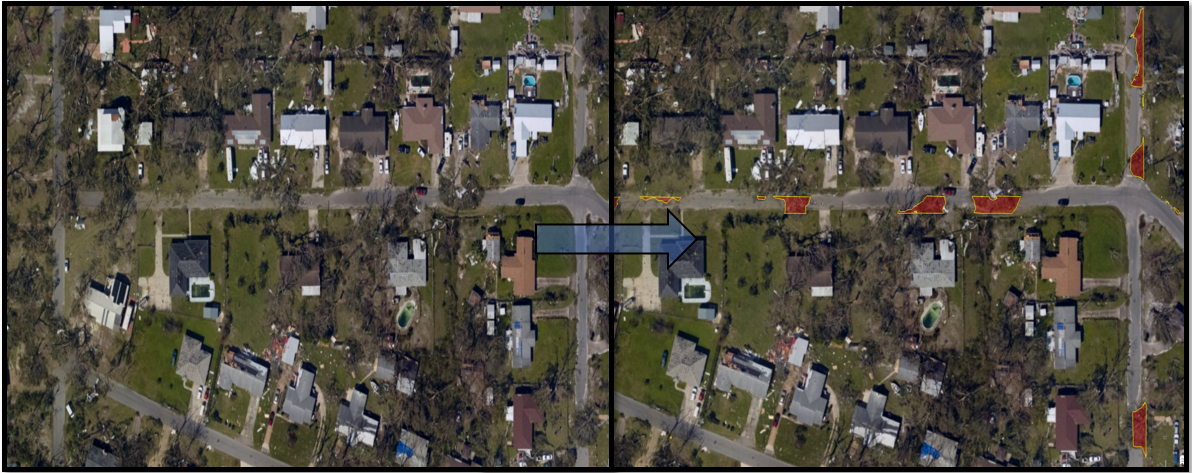

<p>In this notebook, we utilize a dataset of road debris marked with polygons and the arcgis.learn module to train a U-net image segmentation deep learning model to detect road debris. The resulting model is saved as a .dlpk folder (a zipped file extension recognized by other tools) - which contains the raw model script but also auxillary files to upload the model to Portal or run it within a local ArcGIS Pro instance. The resulting model will also be able to run natively on a GPU distributed server inference engine (ImageServer).</p>

In [1]:
## Importing relevant libraries

from arcgis.learn import prepare_data, models, Model
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import os
from PIL import Image
from fastai.vision.transform import rotate, crop, dihedral_affine, brightness, contrast


-----------------------------------

## Inspecting the Raw Data Values

For this use case, the data is the result of running the **Export Training Data for Deep Learning** tool against a feature layer of marked road debris. The tool simply outputs image chips of a specified size along with the corresponding segmentation masks. We can view one of the labels to see what the model would be learning against. Since the labels are simply .tif files, we can read them in as a Numpy array

uint8
[0 1 2]
[[0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 ...
 [0 0 2 2 ... 0 0 0 0]
 [0 0 2 2 ... 0 0 0 0]
 [0 0 2 2 ... 0 0 0 0]
 [0 2 2 2 ... 0 0 0 0]]
(256, 256)


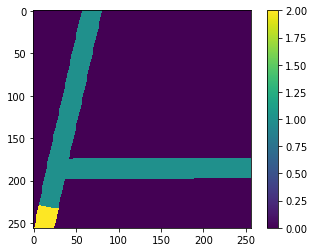

In [2]:
## Inspecting data labels
lbl = plt.imread(r'E:/AI4HADR/Road_Damage_Detection/Second_Run/Chips_256_128_Modify/labels/000000010.tif')
lbl = np.array(lbl)
print(lbl.dtype)
print(np.unique(lbl))
print(lbl)
print(lbl.shape)


plt.imshow(lbl)
plt.colorbar()

---------------------------------------

## Data pre-processing

The prepare_data() method creates a fastai databunch object under the hood, and on the surface it allows a seamless transition from a folder of images and labels (output as images and corresponding masks as above) that comes from a feature class to an object that we can train a model against. We specify parameters such as the chip size (size of images), percentage of data to use as validation, batch size for training, a seed to main reproducability, and a class mapping to tie labels to catagories

In [3]:
chip_size = 256

train_transforms = [rotate(degrees=90, p=0.6),
                    dihedral_affine(), 
                    brightness(change=(0.4, 0.6)), 
                    contrast(scale=(0.75, 1.5))]

val_transforms = [rotate(degrees=90, p=0.5)]

transforms = (train_transforms, val_transforms)


In [4]:
# Prepare Data
data = prepare_data(
    r'E:\AI4HADR\Road_Damage_Detection\Second_Run\Chips_256_128_Modify',
    chip_size=256, 
    val_split_pct=0.1,
    batch_size=6,
    seed=101
    ,class_mapping =  {1: 'unblocked', 2: 'blocked'}
    ,transforms=transforms
)

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\AI4HADR\\Road_Damage_Detection\\Second_Run\\Chips_256_128_Modify\\esri_accumulated_stats.json'

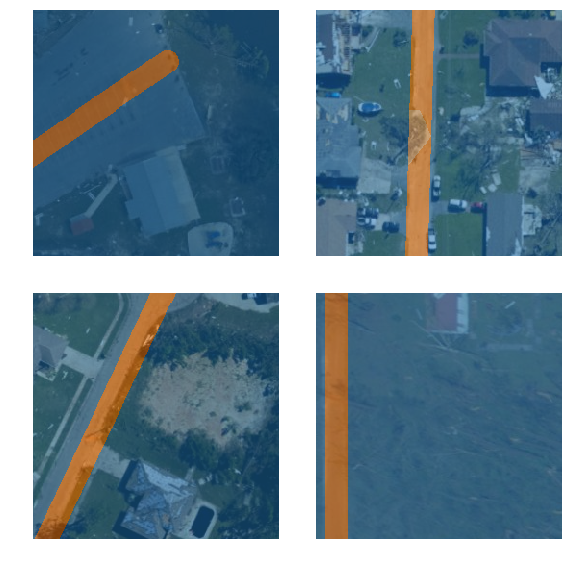

In [21]:
# Inspecting some images with overlaid labels
data.show_batch(rows=2, alpha=0.5)

In [22]:
train_ds_ = data.train_ds.to_df()
print("Training Data Size: " + str(len(train_ds_)))


print()
valid_ds_ = data.valid_ds.to_df()
print("Validation Data Size: " + str(len(valid_ds_)))

del train_ds_, valid_ds_

Training Data Size: 5646

Validation Data Size: 627


-------------------------------------------------

## Model training

Below, we initialize a UnetClassifier() which is a deep learning image segmentation model, such a model intakes an image and outputs a pixel level class map, corresponding each pixel to one of the specified categories. The model can be initilized from scratch or using the weights of a previously trained model.

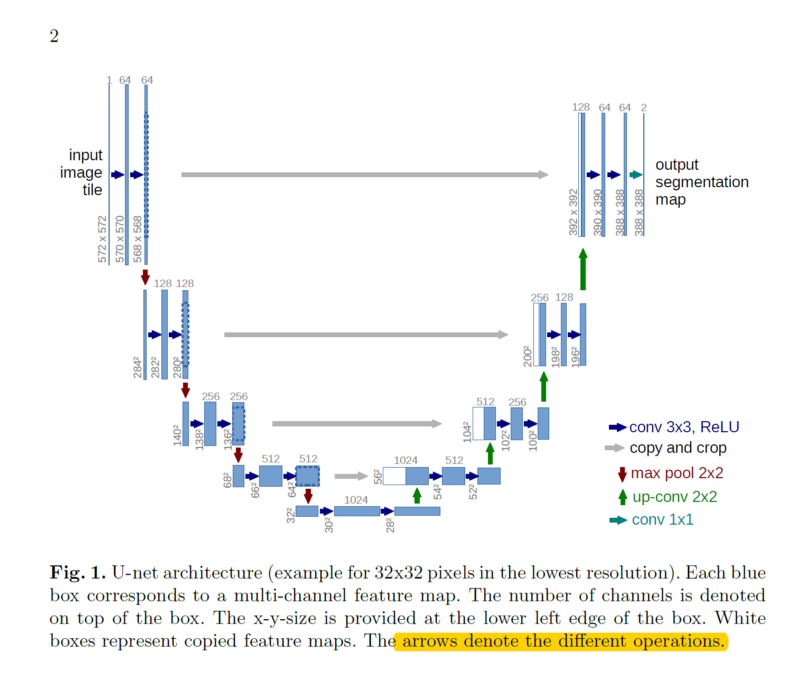

<font size=1>image: "Understanding Semantic Segmentation with UNET" (Lamba, Harshall)</font>

In [23]:
# Create Unet Model
model = models.UnetClassifier(data)#, pretrained_path=r'E:/AI4HADR/Road_Damage_Detection/Second_Run/Chips_256_128_Modify/models/road_damage_modified_3e/')

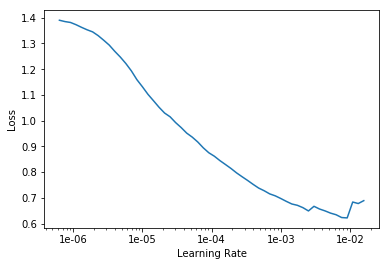

In [24]:
model.lr_find()

<font size=2>
The learning rate finder above is based on the idea of super-convergence, outlined in this paper:
    
Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates (Smith L. N., Topin N., 2018)
https://arxiv.org/abs/1708.07120

In [25]:
model.fit(3, lr=slice(0.0001, 0.001, None))

epoch,train_loss,valid_loss,accuracy
1,0.187179,0.184475,0.548352
2,0.153976,0.150630,0.618484
3,0.136233,0.142728,0.659508


---------------------------

## Saving the Model

The result of the model.save() method will be a zipped folder containing all the model scripts that can then be run locally or uploaded as a Portal item

In [28]:
model.save(r'RoadDebrisModel')
# The resulting saved model can be uploaded to Portal or run locally within ArcGIS Pro

Error: Destination path 'E:\AI4HADR\Road_Damage_Detection\Second_Run\Chips_256_128_Modify\models\road_damage_modified_3e\road_damage_modified_3e.zip' already exists